# CHAPTER 4 전통 퀀트 투자 전략
* 평균 회귀 전략
* 듀얼 모멘텀 전략
* 가치 투자 전략
## 4.1 전통 퀀트 방법론 소개
* 정략적(quantitative) 방법론을 기반으로 투자 의사를 결정하는 것

## 4.2 평균 회귀 전략
### 4.2.1 볼린저 밴드
* 3개의 선으로 구성
    * 중심선 : 이동 평균
    * 상/하단선 : 표준편차 밴드
* ![BB전략](images/BB.PNG)

### 4.2.2 데이터프레임

In [1]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

In [2]:
# df = fdr.DataReader('US500')
df = fdr.DataReader('spy')
# df = fdr.DataReader('^KS11')
df[df['Adj Close'].isna()]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [3]:
df.dropna(inplace=True)
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7660.000000,7660.000000,7660.000000,7660.000000,7660.000000,7.660000e+03
mean,165.932709,166.938927,164.825017,165.941005,138.154481,8.457748e+07
std,101.463488,102.030970,100.857772,101.490969,107.269809,9.305396e+07
min,43.343750,43.531250,42.812500,43.406250,24.726753,5.200000e+03
25%,104.410625,105.394688,103.547503,104.510937,70.664282,9.620125e+06
50%,131.230003,132.112503,130.380005,131.315002,93.489342,6.238815e+07
75%,207.992504,208.972500,207.014996,208.032498,180.530513,1.173612e+08
max,479.220001,479.980011,476.059998,477.709991,466.563324,8.710263e+08


### 4.2.3 데이터 가공

In [4]:
price_df = df.loc[:, ['Adj Close']].copy()
price_df.columns = ['Close']
price_df.head()

,Close
Date,
1993-01-29,25.029366
1993-02-01,25.207375
1993-02-02,25.260796
1993-02-03,25.527821
1993-02-04,25.634619


### 4.2.4 볼린저 밴드 만들기

In [5]:
price_df['center'] = price_df['Close'].rolling(window=20).mean()
price_df.iloc[18:25]

,Close,center
Date,,
1993-02-25,25.260796,NaN
1993-02-26,25.296373,25.220739
1993-03-01,25.225183,25.230529
1993-03-02,25.599031,25.250112
1993-03-03,25.705839,25.272364
1993-03-04,25.563431,25.274145
1993-03-05,25.492220,25.267025


In [6]:
price_df['ub'] = price_df['center'] + 2 * price_df['Close'].rolling(window=20).std()
price_df['lb'] = price_df['center'] - 2 * price_df['Close'].rolling(window=20).std()
price_df.iloc[18:25]

,Close,center,ub,lb
Date,,,,
1993-02-25,25.260796,NaN,NaN,NaN
1993-02-26,25.296373,25.220739,25.864701,24.576777
1993-03-01,25.225183,25.230529,25.868164,24.592895
1993-03-02,25.599031,25.250112,25.908472,24.591752
1993-03-03,25.705839,25.272364,25.961605,24.583124
1993-03-04,25.563431,25.274145,25.966342,24.581948
1993-03-05,25.492220,25.267025,25.946421,24.587629


In [7]:
# bollinder_band(price, window, sigma)
def bollinger_band(price, window=20, sigma=1):
    bb = price.copy()
    bb['center'] = bb['Close'].rolling(window=window).mean()
    bb['ub'] = bb['center'] + sigma * bb['Close'].rolling(window=window).std()
    bb['lb'] = bb['center'] - sigma * bb['Close'].rolling(window=window).std()
    return bb.dropna()

window = 20
sigma = 2
bollinger = bollinger_band(price_df, window, sigma)

In [8]:
# 기간 추출
base_date = '2008-01-01'
sample = bollinger.loc[base_date:]
sample.head()

,Close,center,ub,lb
Date,,,,
2008-01-02,107.151558,109.018051,111.952918,106.083183
2008-01-03,107.099815,108.991162,111.988472,105.993852
2008-01-04,104.475159,108.742953,112.345134,105.140771
2008-01-07,104.386467,108.411986,112.340354,104.483618
2008-01-08,102.700813,107.997838,112.490531,103.505145


In [9]:
# 거래내역을 담을 dataframe 생성
book = sample[['Close']].copy()
book['trade'] = ''
book.head()

,Close,trade
Date,,
2008-01-02,107.151558,
2008-01-03,107.099815,
2008-01-04,104.475159,
2008-01-07,104.386467,
2008-01-08,102.700813,


In [10]:
# create_trade_book(price)
def create_trade_book(price):
    book = price[['Close']].copy()
    book['trade'] = ''
    return book

book = create_trade_book(sample)
book.head()

,Close,trade
Date,,
2008-01-02,107.151558,
2008-01-03,107.099815,
2008-01-04,104.475159,
2008-01-07,104.386467,
2008-01-08,102.700813,


### 4.2.5 거래 전략

In [11]:
def trading(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Close'] > sample.loc[i, 'ub']: # 종가가 상단보다 클시
            book.loc[i, 'trade'] = '' # 보유x
        elif sample.loc[i, 'Close'] < sample.loc[i, 'lb']: # 종가가 하단보다 작을시
            book.loc[i, 'trade'] = 'buy' # 보유o
        elif sample.loc[i, 'lb'] <= sample.loc[i, 'Close'] <= sample.loc[i, 'ub']: # bb 상하단 사이일시
            if book.shift(1).loc[i, 'trade'] == 'buy': # 보유중이면
                book.loc[i, 'trade'] = 'buy' # 여전히 보유
            else: # 보유중이 아니었으면
                book.loc[i, 'trade'] = '' # 보류
    return book

book = trading(sample, book)
print(book.tail(50))

                 Close trade
Date                        
2023-04-20  410.355713      
2023-04-21  410.674530      
2023-04-24  411.102936      
2023-04-25  404.577148      
2023-04-26  402.863495      
2023-04-27  410.883728      
2023-04-28  414.390686      
2023-05-01  413.972260      
2023-05-02  409.319550      
2023-05-03  406.509979      
2023-05-04  403.630676      
2023-05-05  411.102936      
2023-05-08  411.212494      
2023-05-09  409.409210      
2023-05-10  411.322113      
2023-05-11  410.604767      
2023-05-12  410.066772      
2023-05-15  411.481506      
2023-05-16  408.731720      
2023-05-17  413.693298      
2023-05-18  417.678497      
2023-05-19  417.070740      
2023-05-22  417.240143      
2023-05-23  412.557526      
2023-05-24  409.568604      
2023-05-25  413.115448      
2023-05-26  418.465546      
2023-05-30  418.624969      
2023-05-31  416.303619      
2023-06-01  420.258911      
2023-06-02  426.336334      
2023-06-05  425.519379      
2023-06-06  42

### 4.2.6 전략 수익률

In [12]:
def returns(book):
    book['return'] = 1
    buy = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':
            buy = book.loc[i, 'Close']
            print(f"진입일 : {i.strftime('%Y-%m-%d')}, 진입가격 : {buy}")
        elif buy != 0.0 and book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':
            sell = book.loc[i, 'Close']
            rtn = sell / buy
            book.loc[i, 'return'] = rtn
            print(f"청산일 : {i.strftime('%Y-%m-%d')}, 진입가격 : {buy}, 청산가격 : {sell}, return : {round(rtn, 4)}")
            buy = 0.0

    book['acc_ret'] = book['return'].cumprod()
    print(f"기간: {book.index[0].strftime('%Y/%m/%d')} ~ {book.index[-1].strftime('%Y/%m/%d')}")
    print(f"Accumulated return : {book.iloc[-1]['acc_ret']}")
    return round(book.iloc[-1]['acc_ret'], 4)
    # acc_rtn = 1.0
    # for i in book.index:
    #     rtn = book.loc[i, 'return']
    #     acc_rtn = acc_rtn * rtn
    #     book.loc[i, 'acc_ret'] = acc_rtn
    # print(f"기간: {book.index[0].strftime('%Y/%m/%d')} ~ {book.index[-1].strftime('%Y/%m/%d')}")
    # print(f"Accumulated return : {acc_rtn}")
    # return round(acc_rtn, 4)

returns(book)
print(book.loc['2008':'2008-02-02'])

진입일 : 2008-01-04, 진입가격 : 104.475159
청산일 : 2008-04-01, 진입가격 : 104.475159, 청산가격 : 101.500351, return : 0.9715
진입일 : 2008-06-06, 진입가격 : 101.262573
청산일 : 2009-01-02, 진입가격 : 101.262573, 청산가격 : 70.382668, return : 0.6951
진입일 : 2009-01-20, 진입가격 : 61.001854
청산일 : 2009-03-23, 진입가격 : 61.001854, 청산가격 : 62.696678, return : 1.0278
진입일 : 2010-01-22, 진입가격 : 84.600227
청산일 : 2010-04-14, 진입가격 : 84.600227, 청산가격 : 94.267197, return : 1.1143
진입일 : 2010-05-04, 진입가격 : 91.412506
청산일 : 2010-10-13, 진입가격 : 91.412506, 청산가격 : 92.653404, return : 1.0136
진입일 : 2011-03-10, 진입가격 : 102.63485
청산일 : 2011-04-26, 진입가격 : 102.63485, 청산가격 : 106.928154, return : 1.0418
진입일 : 2011-05-23, 진입가격 : 104.762482
청산일 : 2011-06-30, 진입가격 : 104.762482, 청산가격 : 105.210075, return : 1.0043
진입일 : 2011-08-02, 진입가격 : 100.04409
청산일 : 2012-02-03, 진입가격 : 100.04409, 청산가격 : 108.497665, return : 1.0845
진입일 : 2012-04-10, 진입가격 : 110.074692
청산일 : 2012-07-03, 진입가격 : 110.074692, 청산가격 : 111.874474, return : 1.0164
진입일 : 2012-10-23, 진입가격 : 115.753845
청산일 : 

In [13]:
def returns2(book):
    book['return'] = 1
    buy = 0.0
    for i,x in enumerate(book.index):
        if book.loc[x, 'trade'] == 'buy' and (i==0 or book.shift(1).loc[x, 'trade'] == ''):
            buy = book.loc[x, 'Close']
            print(f"진입일 : {x.strftime('%Y-%m-%d')}, 진입가격 : {buy}")
        elif buy != 0.0 and book.loc[x, 'trade'] == '' and book.shift(1).loc[x, 'trade'] == 'buy':
            sell = book.loc[x, 'Close']
            rtn = sell / buy
            print(f"청산일 : {x.strftime('%Y-%m-%d')}, 진입가격 : {buy}, 청산가격 : {sell}, return : {round(rtn, 4)}")
            buy = 0.0
        if book.shift(1).loc[x, 'trade'] == 'buy' and i!=0:
            book.loc[x, 'return'] = book.loc[x, 'Close'] / book.shift(1).loc[x, 'Close']
    book['acc_ret'] = book['return'].cumprod()
    print(f"기간: {book.index[0].strftime('%Y/%m/%d')} ~ {book.index[-1].strftime('%Y/%m/%d')}")
    print(f"Accumulated return : {book.iloc[-1]['acc_ret']}")
    return round(book.iloc[-1]['acc_ret'], 4)

returns2(book)
book.loc['2008-03':'2008-04-02']

진입일 : 2008-01-04, 진입가격 : 104.475159
청산일 : 2008-04-01, 진입가격 : 104.475159, 청산가격 : 101.500351, return : 0.9715
진입일 : 2008-06-06, 진입가격 : 101.262573
청산일 : 2009-01-02, 진입가격 : 101.262573, 청산가격 : 70.382668, return : 0.6951
진입일 : 2009-01-20, 진입가격 : 61.001854
청산일 : 2009-03-23, 진입가격 : 61.001854, 청산가격 : 62.696678, return : 1.0278
진입일 : 2010-01-22, 진입가격 : 84.600227
청산일 : 2010-04-14, 진입가격 : 84.600227, 청산가격 : 94.267197, return : 1.1143
진입일 : 2010-05-04, 진입가격 : 91.412506
청산일 : 2010-10-13, 진입가격 : 91.412506, 청산가격 : 92.653404, return : 1.0136
진입일 : 2011-03-10, 진입가격 : 102.63485
청산일 : 2011-04-26, 진입가격 : 102.63485, 청산가격 : 106.928154, return : 1.0418
진입일 : 2011-05-23, 진입가격 : 104.762482
청산일 : 2011-06-30, 진입가격 : 104.762482, 청산가격 : 105.210075, return : 1.0043
진입일 : 2011-08-02, 진입가격 : 100.04409
청산일 : 2012-02-03, 진입가격 : 100.04409, 청산가격 : 108.497665, return : 1.0845
진입일 : 2012-04-10, 진입가격 : 110.074692
청산일 : 2012-07-03, 진입가격 : 110.074692, 청산가격 : 111.874474, return : 1.0164
진입일 : 2012-10-23, 진입가격 : 115.753845
청산일 : 

,Close,trade,return,acc_ret
Date,,,,
2008-03-03,98.700981,buy,0.997608,0.944732
2008-03-04,98.323921,buy,0.996180,0.941122
2008-03-05,98.944954,buy,1.006316,0.947067
2008-03-06,96.897018,buy,0.979302,0.927465
2008-03-07,95.898941,buy,0.989700,0.917911
2008-03-10,94.634644,buy,0.986816,0.905810
2008-03-11,98.035599,buy,1.035938,0.938363
2008-03-12,97.118835,buy,0.990649,0.929588
2008-03-13,97.333214,buy,1.002207,0.931640


In [14]:
def get_evaluation(daily_return):
    """
    cagr, dd, mdd, vol, sharpe
    투자 성과 지표
    """
    # cumulativeReturn
    cumulativeReturn = daily_return.cumprod()
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    vol = np.std(daily_return-1) * np.sqrt(252)
    sharpe = np.mean(daily_return-1) * 252 / vol

    print(f"기간: {daily_return.index[0].strftime('%Y/%m/%d')} ~ {daily_return.index[-1].strftime('%Y/%m/%d')}")
    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}\nvol: {vol}\nsharpe: {sharpe}")

    return cagr, dd, mdd, vol, sharpe

cagr, _, mdd, vol, sharp = get_evaluation(book.loc[:,'return'])

기간: 2008/01/02 ~ 2023/06/30
최종 수익률: 2.770653269426497
cagr: 1.0680468092820603
mdd: 45.634505469036554
vol: 0.1814205752651017
sharpe: 0.45367648461137533


<Axes: xlabel='Date'>

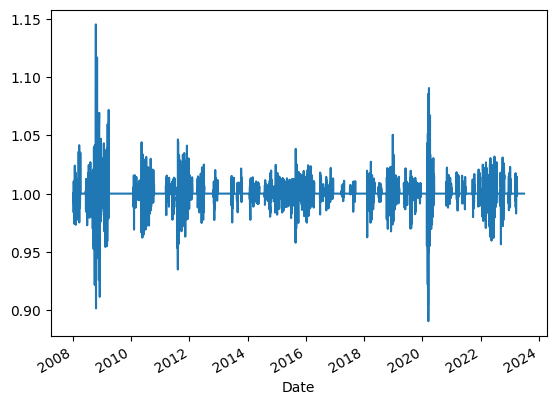

In [15]:
book['return'].plot()

### 4.2.7 변화 추이

<Axes: xlabel='Date'>

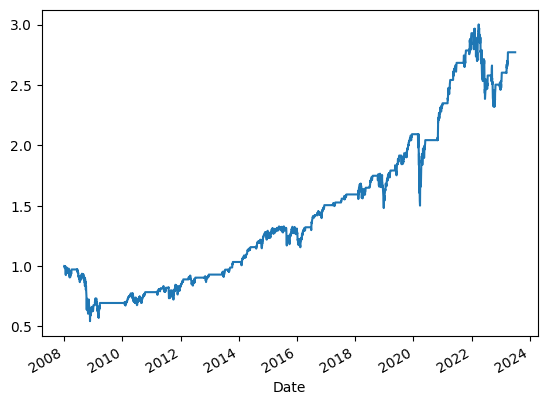

In [16]:
book['acc_ret'].plot()